<a href="https://colab.research.google.com/github/Hanton-MENEZ/BigData-Samuel-Valentin-Hanton-/blob/main/pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import des bibliothèques
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import os
from textwrap import wrap
import seaborn as sns
import pathlib
import PIL
from pickle import load
import tensorflow as tf
from google.colab import drive

from tensorflow import keras
from keras import layers
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.applications.inception_v3 import preprocess_input, InceptionV3

from google.colab import drive
# connexion drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dataset_dir_path = pathlib.Path("/content/drive/MyDrive/dataset")

## Chargement du modèle de tri des photos

In [3]:
# Load model_tri_photos.h5
model_photos = keras.models.load_model('/content/drive/MyDrive/Models/Binary')

## Chargement du modèle de débruitage des images

In [4]:
# Load model_denoise.h5
model_denoise = keras.models.load_model('/content/drive/MyDrive/Models/AE/model_denoise.h5')

## Chargement du modèle de caption

In [5]:
# Load model_30_caption.h5
model_caption = keras.models.load_model('/content/drive/MyDrive/Models/Checkpoints/model_30_caption.h5')

## Uniformisation des images pour le dataset

Uniformisation des types de fichiers, et des noms de fichiers.

In [6]:
# Transforme en jpg
def to_jpg():
    for dir in os.listdir(dataset_dir_path):
        for file in os.listdir(dataset_dir_path/dir):
            if not file.endswith(".jpg"):
                im = PIL.Image.open(dataset_dir_path/dir/file)
                rgb_im = im.convert('RGB')
                rgb_im.save(str(dataset_dir_path/dir/file).split(".")[0]+".jpg")
                os.remove(dataset_dir_path/dir/file)

# Appel de la fonction de transformation
to_jpg()

In [7]:
# Formater les noms des fichiers
def format_file_name():
    for dir in os.listdir(dataset_dir_path):
        for index, file in enumerate(os.listdir(dataset_dir_path/dir)):
            os.rename(dataset_dir_path/dir/file, dataset_dir_path/dir/f"{index:03d}.jpg")

# Appel de la fonction de formatage
format_file_name()

## Chargement du dataset

In [8]:
# Load dataset
dataset = keras.preprocessing.image_dataset_from_directory(
    dataset_dir_path,
    image_size=(180, 180),
    shuffle=True,
)

Found 56 files belonging to 1 classes.


## Classifications en photos et non-photo

In [9]:
# Predictions photo-nophoto
predictions_photos = model_photos.predict(dataset)

2/2 [==============================] - 11s 407ms/step


In [10]:
# Prédire les classes sur l'ensemble de test
y_pred_classes = np.round(predictions_photos)

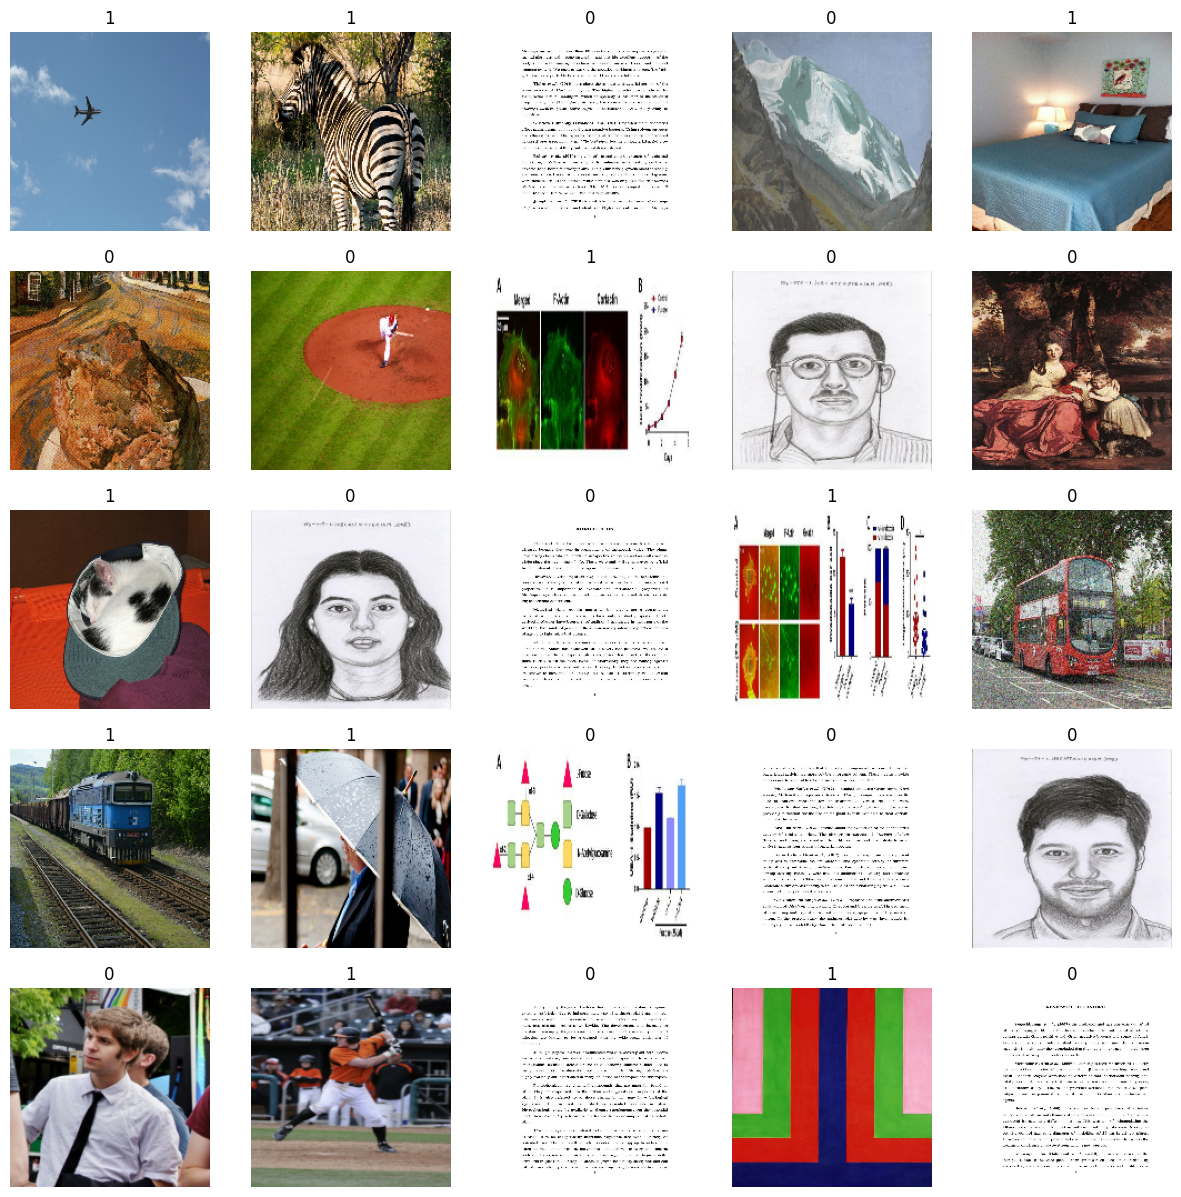

In [11]:
# Show predictions photo-nophoto
plt.figure(figsize=(15, 15))
for images, labels in dataset.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(y_pred_classes[i]))
        plt.axis("off")
plt.show()

In [12]:
# Get only photos
dataset_photos = []
dataset_unbatched = list(dataset.unbatch())
for i in range(len(predictions_photos)):
    if int(y_pred_classes[i]) == 1:
        dataset_photos.append(dataset_unbatched[i])


## Débruitage des images

In [13]:
batch_size = 32
img_height = 700
img_width = 700

In [14]:
# Resize photos
def resize_set(set): return set.map(lambda x, y: (tf.image.resize(x, [img_height, img_width]), y))

dataset_photos = resize_set(tf.data.experimental.from_list(dataset_photos))

In [15]:
preprocessing_not_noised = keras.Sequential(
    [
        layers.experimental.preprocessing.Rescaling(1.0 / 255),
    ]
)

dataset_photos_preprocessed = []

# Apply preprocessing
for images, _ in dataset_photos.as_numpy_iterator():
    dataset_photos_preprocessed.append(preprocessing_not_noised(images, training=True).numpy())

dataset_photos_preprocessed_np = np.array(dataset_photos_preprocessed)

In [16]:
dataset_photos_preprocessed_np.shape

(14, 700, 700, 3)

In [17]:
# Denoise photos
dataset_denoise = model_denoise.predict(dataset_photos_preprocessed_np)

1/1 [==============================] - 7s 7s/step


In [18]:
postprocessing_not_noised = keras.Sequential(
    [
        layers.experimental.preprocessing.Rescaling(255),
    ]
)

In [19]:
# Apply postprocessing
dataset_denoise_postprocessed = []
for images in dataset_denoise:
    dataset_denoise_postprocessed.append(postprocessing_not_noised(images, training=True).numpy())

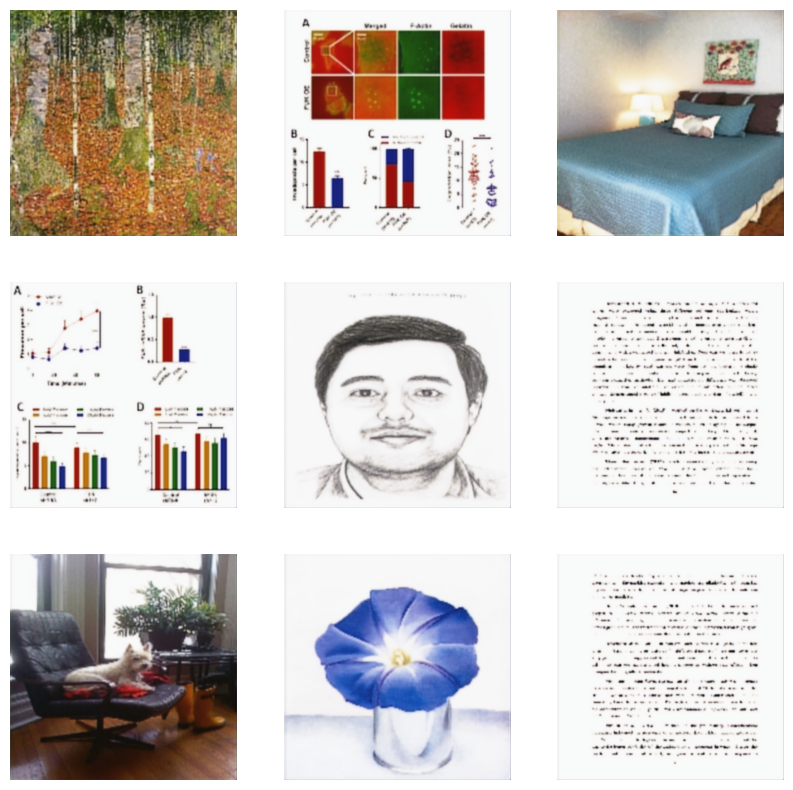

In [20]:
# Show denoised photos
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((dataset_denoise_postprocessed[i]).astype("uint8"))
    plt.axis("off")
plt.show()

## Génération des captions

In [21]:
def preprocess_image(images: np.ndarray):
    # Resize images
    images = tf.image.resize(images, [299, 299])
    images = preprocess_input(images)
    return images

In [22]:
# Load Inception-V3 model
model = InceptionV3(weights='imagenet')

# Create new model, by removing last layer (output layer) from Inception-V3
model_new = Model(inputs=model.input, outputs=model.layers[-2].output) # outputs=(second last layer output)

96112376/96112376 [==============================] - 0s 0us/step


In [23]:
# Function to encode given image into a vector of size (2048, )
def encode_image(images):
    images = preprocess_image(images) # preprocess image
    feature_vector = model_new.predict(images, verbose=1) # Get encoding vector for image
    print(feature_vector.shape)
    feature_vector = feature_vector.reshape(feature_vector.shape[0], -1) # reshape from (1, 2048) to (2048, )
    return feature_vector

In [24]:
# Encode all images
encoding_dataset = encode_image(dataset_denoise_postprocessed)

1/1 [==============================] - 4s 4s/step
(14, 2048)


In [25]:
def greedySearch(photo, max_length, wordtoix, ixtoword):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model_caption.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [26]:
def predict_all(encoding_test, max_length_caption, word_to_index, index_to_word):
    predictions = []
    for image in encoding_test:
        img = np.expand_dims(image, axis=0)
        img = img.reshape((1,2048))
        predictions.append(greedySearch(img, max_length_caption, word_to_index, index_to_word))

    return predictions

In [27]:
# Load index_to_word and word_to_index from disk
index_to_word = load(open('/content/drive/MyDrive/Captions/index_to_word.pkl','rb'))
word_to_index = load(open('/content/drive/MyDrive/Captions/word_to_index.pkl','rb'))

In [28]:
max_length_caption = 40

# Predict captions
predictions = predict_all(encoding_dataset, max_length_caption, word_to_index, index_to_word)

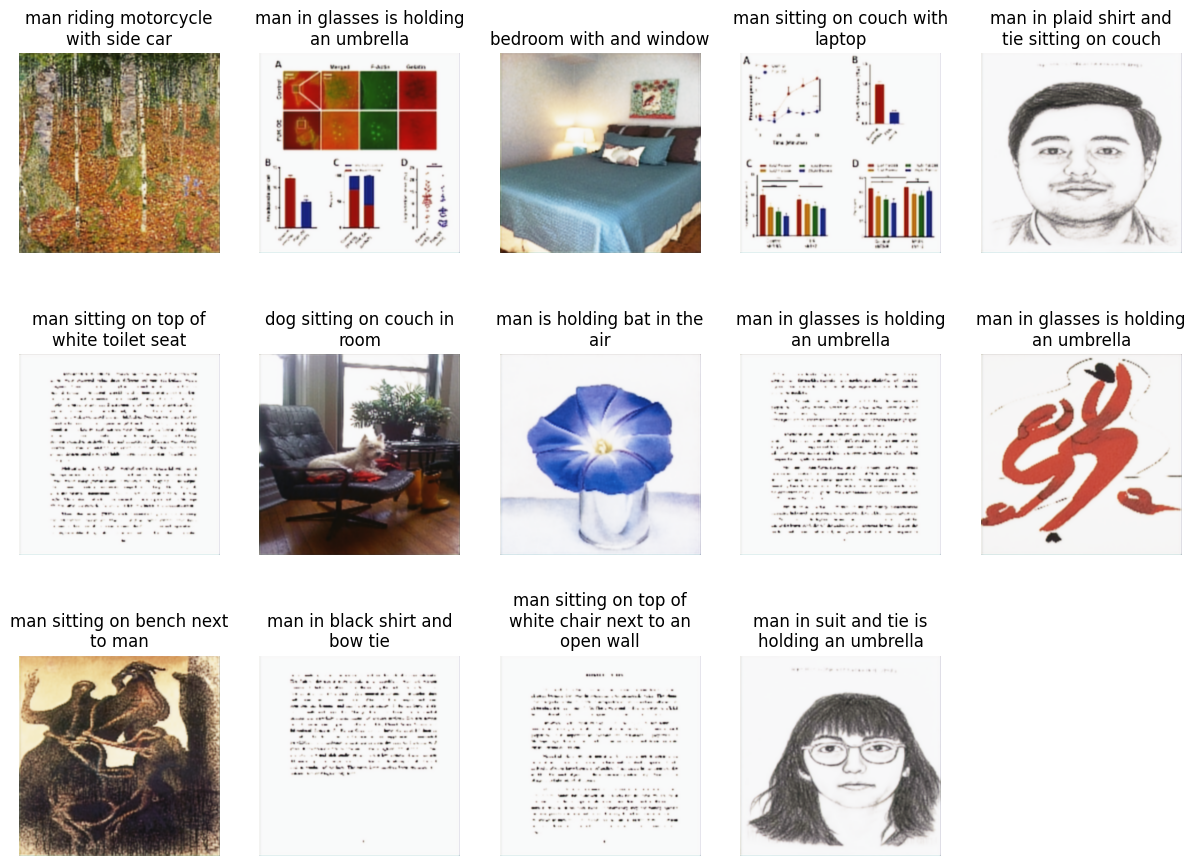

In [29]:
# Show captions
plt.figure(figsize=(15, 15))
for i in range(len(dataset_denoise_postprocessed)):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow((dataset_denoise_postprocessed[i]).astype("uint8"))
    plt.title("\n".join(wrap(predictions[i], 25)))
    plt.axis("off")